# Introduction
This is the third part of our series about Covid19 data analysis. This series is inspired after the proposed [Kaggle challenge](https://www.kaggle.com/c/covid19-global-forecasting-week-2). This notebook introduces some practical examples of univariate time series forecasting.

We introduces the [Python statsmodel](https://www.statsmodels.org) module which provides a set of statistical tools for conducting statistical tests and data exploration. We focus on the time series analysis module offered in this package to run basic time series forecasting predicting the evolution of cases in the Covid19 pandemia.

**Assumptions**
* You succesfully run the [Covid19 visualization notebook](./Covid19%20plots%20visualization.ipynb)
* You have an already running Jupyter environment
* You are familiar with Pandas
* You have heard about Matplotlib
* The covid19 files are available in the path covid19-global-forecasting-week-2

# Load the data

Load the CSV data using pandas. In this case, we use the `read_csv` function indicating the date parser to be used. Working with dates is going to be particularly useful when working with time series.

In [1]:
import pandas as pd
import datetime

In [2]:
data = pd.read_csv('covid19-global-forecasting-week-2/train.csv',parse_dates=['Date'], 
                   date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
data


,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,NaN,2020-01-22,0.0,0.0
1,2,Afghanistan,NaN,2020-01-23,0.0,0.0
2,3,Afghanistan,NaN,2020-01-24,0.0,0.0
3,4,Afghanistan,NaN,2020-01-25,0.0,0.0
4,5,Afghanistan,NaN,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
18811,29360,Zimbabwe,NaN,2020-03-21,3.0,0.0
18812,29361,Zimbabwe,NaN,2020-03-22,3.0,0.0
18813,29362,Zimbabwe,NaN,2020-03-23,3.0,1.0
18814,29363,Zimbabwe,NaN,2020-03-24,3.0,1.0


China was the origin of Covid19. Its curve of infection is the longest one among the curves available in the dataset. We are going to get a sample filtering all the data corresponding to China. Remember that in the case of China we have information about the evolution for every province. In order, to work with an aggregated value per country and day, we have to aggregate the data. Check the previous notebooks for more details about this operation.

In [3]:
china = data.where(data.Country_Region=='China').groupby(['Date'],as_index=False).sum()
china

,Date,Id,ConfirmedCases,Fatalities
0,2020-01-22,214533.0,548.0,17.0
1,2020-01-23,214566.0,643.0,18.0
2,2020-01-24,214599.0,920.0,26.0
3,2020-01-25,214632.0,1406.0,42.0
4,2020-01-26,214665.0,2075.0,56.0
...,...,...,...,...
59,2020-03-21,216480.0,81305.0,3259.0
60,2020-03-22,216513.0,81435.0,3274.0
61,2020-03-23,216546.0,81498.0,3274.0
62,2020-03-24,216579.0,81591.0,3281.0


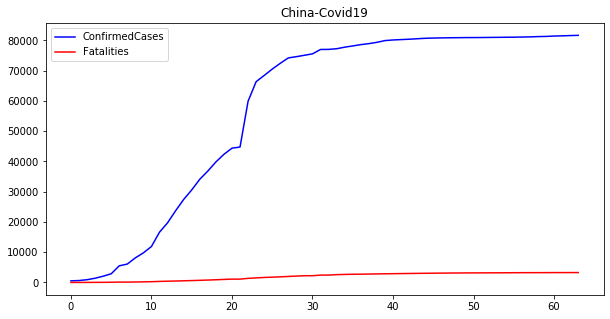

In [4]:
import matplotlib.pyplot as pyplot

fig = pyplot.figure(figsize=(10,5))
ax1 = fig.add_subplot()
china.ConfirmedCases.plot(ax=ax1,color='blue',legend=True, title='China-Covid19')
china.Fatalities.plot(ax=ax1,color='red',legend=True)
pyplot.show()

# Univariate time series analysis
The plot above shows the evolution of confirmed cases and fatalities for China during the Covid19 crisis. This seems the common profile of any pandemic. First, the number of cases increases until it reaches a plateau. Then, it stays stable until the cases decrease with an increment in the number of fatalities. 

One of the most important problems to be resolved in this case, like in any other time series is: **can we forecast the number of new cases and/or fatalities with some accuracy?** 

We start working with the China time series. Before starting we need to make some preparation to work with datetime indices. These are common operations in Pandas. We remove the `Id` column and convert the `Date` column into our new row index. Additionally, we set the frequency of the index to days by executing `china.index.freq='d'`. This is particularly helpful when using Pandas time series.

In [5]:
china = china.set_index('Date')
china.drop(['Id'], axis=1, inplace=True)
# The index is a time series with a frequency of days
china.index.freq='d'

## Simple exponential smoothing

If we try to predict any future value in an univariate time series, the first thing we have to consider is the fact that future observations depend on past and present observations. If $\hat{y}_t$ is the forecast of variable $x$ at time $t$ and $\hat{y}_{t+h|t}$ the forecast of variable $x$ at time $t+h$ given time $t$, a forecast equation could be something like this.

\begin{align}
\hat{y}_{t+h|t} = l_t
\end{align}


Which basically means that our predictions at time $t+h$ given observations at time $t$ are the result of a function $l$ at time $t$. And what is this function? We are going to use a simple exponential smoothing (SES) function.

\begin{align}
l_1 &= \alpha y_1 + (1- \alpha) l_{0}
\end{align}


Which is a formal way of saying that the current value depends on the previous value multiplied by a smoothing factor $ \alpha $. If we continue developing the equation we have

\begin{align*}
l_1 &=\alpha y_1 + (1-\alpha) l_{0} \\
l_2 &=\alpha y_2 + (1-\alpha) l_{1} = \alpha y_2 + \alpha(1-\alpha) y_1 + (1-\alpha)^2 l_{0} \\
l_3 &=\alpha y_3 + (1-\alpha) l_{2} = \sum_{j=0}^{2}\alpha(1-\alpha)^jy_{3-j}+(1-\alpha)^3l_{0} \\
\vdots \\
l_t &= \sum_{j=0}^{t-1}\alpha(1-\alpha)^j y_{t-j}+(1-\alpha)^tl_0
\end{align*}

Therefore, the forecasting equation is:

\begin{align*}
\hat{y}_{t+h|t} &= \sum_{j=1}^{t}\alpha(1-\alpha)^{t-j} y_{j}+(1-\alpha)^tl_0 
\end{align*}

The $\alpha$ value should be chosen to minimize the mean squared error (MSE) 

\begin{align*}
MSE = \frac{1}{T} \sum_{t=1}^{T} (y_t+\hat{y}_{t|t-1})^2
\end{align*}

There is no closed solution to find $\alpha$. [Least squares](https://en.wikipedia.org/wiki/Least_squares) can be a simple and valid method to set the value. 

We are going to use the implementation available at the statsmodels library to make some predictions for the number of confirmed cases in China starting at 2020-03-20.



In [6]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [7]:
# We previously set dates as the row index. Now we can use indexes to select rows.
china_train = china[:'2020-03-20']
china_test = china['2020-03-21':] 

# Chose a model for confirmed cases
model = SimpleExpSmoothing(china_train.ConfirmedCases)
# Fit the model for the given observations
model_fit = model.fit()


We have fit a model using SES and the number of confirmed cases. It is extremely useful to check what are the params for this model and understand how well our fitting process did.

In [8]:
# Check the params for the model
display(model_fit.params)
# Lets observe a summary about the fitting
model_fit.summary()

{'smoothing_level': 1.0,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 548.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Dep. Variable:,endog,No. Observations:,59
Model:,SimpleExpSmoothing,SSE,421717800.000
Optimized:,True,AIC,935.156
Trend:,None,BIC,939.311
Seasonal:,None,AICC,935.897
Seasonal Periods:,None,Date:,"Fri, 03 Apr 2020"
Box-Cox:,False,Time:,17:37:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,548.00000,l.0,True


We can set the $\alpha$ parameter by setting the `smoothing_level` value in the `model.fit` call. However, if we do not set any value, the library will find it for us. In this case $\alpha$ was automatically set to 1 with $l_0=548$ (`initial_level` in the summary table). 

Now we are going to fit some models manually setting the $\alpha$ parameter and compare the obtained output.

In [9]:
import matplotlib.pyplot

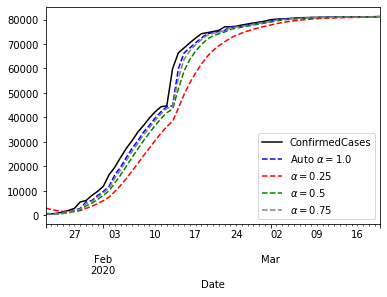

In [10]:
# Fit with some alphas
fit025 = model.fit(smoothing_level=0.25)
fit05 = model.fit(smoothing_level=0.5)
fit075 = model.fit(smoothing_level=0.75)

ax = china_train.ConfirmedCases.plot(color='black', legend=True)
model_fit.fittedvalues.plot(ax=ax, color='blue', style='--', legend=True, label=r'Auto $\alpha=%s$'%model_fit.params['smoothing_level'])
fit025.fittedvalues.plot(ax=ax, color='red', style='--', legend=True, label=r'$\alpha=0.25$' )
fit05.fittedvalues.plot(ax=ax, color='green', style='--', legend=True, label=r'$\alpha=0.5$')
fit075.fittedvalues.plot(ax=ax, color='grey', style='--', legend=True, label=r'$\alpha=0.75$' )

pyplot.show()

The plot above shows that $\alpha=1$ gives the best approximation to the curve. Now that we know that $\alpha=1$  brings the best performance, we can think about forecasting with that model.


In [11]:
# Lets make some predictions
predicted = model_fit.predict(start='2020-03-21',end='2020-03-25').rename('Predicted ConfirmedCases')


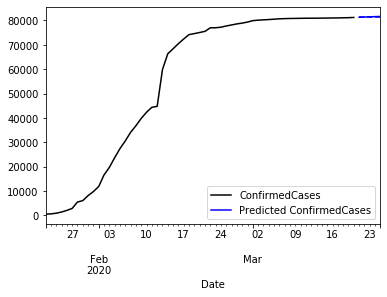

In [12]:
ax = china_train.ConfirmedCases.plot(color='black', legend=True)
china_test.ConfirmedCases.plot(ax = ax, color='blue', legend=False)
predicted.plot(ax=ax, color='blue', style='--', legend=True)
pyplot.show()

The plot the whole time series and a five days prediction. We better use some zoom.

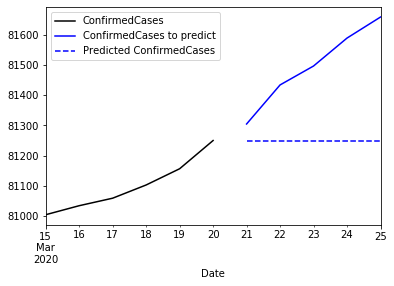

In [13]:
ax = china_train.ConfirmedCases['2020-03-15':'2020-03-25'].plot(color='black',legend=True)
china_test.ConfirmedCases.plot(ax = ax, color='blue', legend=True, label='ConfirmedCases to predict')
predicted.plot(ax=ax, color='blue', style='--', legend=True)
pyplot.show()

Observe that the iterative prediction always returns the same value. This is because this function is a **flat forecast function**. There is no trend, seasonality or other value that can make this prediction to evolve. So finally, what we have is the mean of a future:

\begin{align*}
\hat{y}_{T+h|T} = \hat{y}_{T+1|T}, \space h=2,3,...
\end{align*}

## Holt-Winters

The flat nature of multiple steps forecasting of SES is not a good solution if we need a prediction at $T+h$. However, there are other approaches which basically include additional elemnts such as seasonality or trend. For example, the Holt's local trend method adds a $\beta^*$ factor that controls the trend:

\begin{align*}
Forecast: && \hat{y}_{t+h|t} &= l_t + hb_t \\
Level: && l_t &= \alpha y_t + (1-\alpha)(l_{t-1}+b_{t-1}) \\
Trend: && b_t &= \beta^*(l_t-l_{t-1})+(1-\beta^*)b_{t-1}
\end{align*}

In this approach, $l_t$ estimates the level while $bt$ estimates the slope. The extension of the formula requires to estimate $\alpha$, $\beta=\alpha\beta^*$,$l_0$ and $b_0$.

Let's compare the forecast obtained from Holt-Winters for the previous scenario.

In [14]:
from statsmodels.tsa.holtwinters import Holt

# Fit a Holt-Winters model
holt_model = Holt(china_train.ConfirmedCases)
holt_fitted = holt_model.fit()
holt_fitted.summary()

Dep. Variable:,endog,No. Observations:,59
Model:,Holt,SSE,243476583.261
Optimized:,True,AIC,906.747
Trend:,Additive,BIC,915.057
Seasonal:,None,AICC,908.362
Seasonal Periods:,None,Date:,"Fri, 03 Apr 2020"
Box-Cox:,False,Time:,17:38:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,0.2715660,beta,True


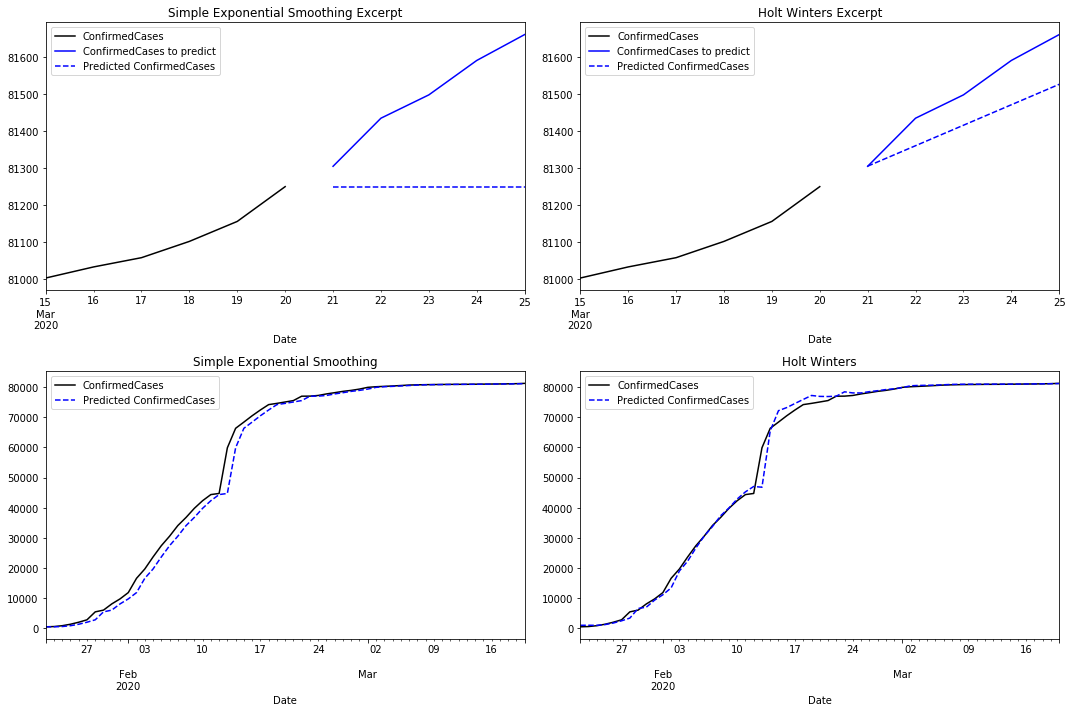

In [15]:
holt_predicted = holt_fitted.predict(start='2020-03-21', end='2020-03-25').rename('Predicted ConfirmedCases')

fig = pyplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
china_train.ConfirmedCases['2020-03-15':'2020-03-25'].plot(ax=ax1,color='black',legend=True, 
                                                           title='Simple Exponential Smoothing Excerpt')
china_test.ConfirmedCases.plot(ax = ax1, color='blue', legend=True, label='ConfirmedCases to predict')
predicted.plot(ax=ax1, color='blue', style='--', legend=True)

ax2 = fig.add_subplot(2,2,2)
china_train.ConfirmedCases['2020-03-15':'2020-03-25'].plot(ax=ax2, color='black',legend=True, 
                                                           title='Holt Winters Excerpt')
china_test.ConfirmedCases.plot(ax = ax2, color='blue', legend=True, label='ConfirmedCases to predict')
holt_predicted.plot(ax=ax2, color='blue', style='--', legend=True)

ax4 = fig.add_subplot(2,2,3)
china_train.ConfirmedCases.plot(ax=ax4, color='black',legend=True, title='Simple Exponential Smoothing')
model_fit.fittedvalues.plot(ax=ax4, color='blue', style='--', legend=True, label='Predicted ConfirmedCases')

ax3 = fig.add_subplot(2,2,4)
china_train.ConfirmedCases.plot(ax=ax3, color='black',legend=True, title='Holt Winters')
holt_fitted.fittedvalues.plot(ax=ax3, color='blue', style='--', legend=True, label='Predicted ConfirmedCases')

pyplot.tight_layout()
pyplot.show()


Comparing SES with the Holt Winters predictions there are clear differences. As we mentioned before, the prediction for the next five days is flat in the first case. Holt Winters uses its trend component to predict an increment in the number of cases. 

When comparing how both models fit the time series, SES reacts with some latency returning an approximation with some lag. Holt Winters reacts earlier by capturing the trend. However, it reacts with some latency when the trend changes. If we compare the residuals for both models we notice that Holt Winters performs better than SES.

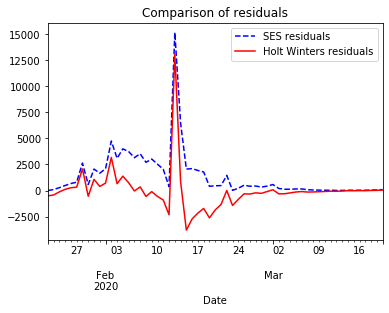

In [16]:
ax=model_fit.resid.plot(color='blue', style='--', legend=True, label='SES residuals', title='Comparison of residuals')
holt_fitted.resid.plot(ax=ax, color='red', legend=True, label='Holt Winters residuals')
pyplot.show()


At the moment of writing this notebook the most complete Covid-19 time series corresponds to China. However, we can check the quality of the fitting models for every country in the dataset. We can expect that any Holt Winters model will return better predictions than SES. For the sake of exhaustiveness we compare the performance of SES and Holt Winters predicting the number of confirmed cases and fatilities for every country in the dataset. The range of observed values for every country in the dataset may dramatically vary. This makes useless the comparison of RMSE values. We employ the Normalized Squared Error (NRMSE) which normalizes the RMSE using the max and min observed values. This is, $\mathit{NRMSE} = \frac{\mathit{RMSE}}{y_{max}-y_{min}}$.

**Note:** Observations may dramatically vary between countries. We ignore countries with no fatalities nor confirmed cases.

In [17]:
# Accumulate observations per country and date. This is required to aggregate observations for multiple provinces
# in the same country.
data=data.groupby(['Country_Region','Date'],as_index=False,).sum()
display(data)

,Country_Region,Date,Id,ConfirmedCases,Fatalities
0,Afghanistan,2020-01-22,1,0.0,0.0
1,Afghanistan,2020-01-23,2,0.0,0.0
2,Afghanistan,2020-01-24,3,0.0,0.0
3,Afghanistan,2020-01-25,4,0.0,0.0
4,Afghanistan,2020-01-26,5,0.0,0.0
...,...,...,...,...,...
11067,Zimbabwe,2020-03-21,29360,3.0,0.0
11068,Zimbabwe,2020-03-22,29361,3.0,0.0
11069,Zimbabwe,2020-03-23,29362,3.0,1.0
11070,Zimbabwe,2020-03-24,29363,3.0,1.0


In [18]:
import numpy as np


def computeErrors(ymax,ymin,fitted):
    '''
    Compute the normalized RMSE for this model
    $$
    \mathit{NRMSE} = \frac{\mathit{RMSE}}{y_{max}-y_{min}}
    $$
    '''
    RMSE = np.sqrt(np.sum(np.power(fitted.resid,2))/len(fitted.resid))
    NRMSE = RMSE / (ymax-ymin)
    return NRMSE

# Fit a model for every country 

# Get the list of all the available countries
countries = data.Country_Region.unique()


nrmse = pd.DataFrame(columns=['SES-Confirmed','SES-Fatalities','HoltWinters-Confirmed','HoltWinters-Fatalities'],
                    index=countries)

# Because we are blindly computing a large number of models, some of them may result in convergence problems.
# We ignore them.
import warnings
warnings.filterwarnings('ignore')

for country in countries:
    excerpt = data[data.Country_Region==country]
    maxConfirmed = excerpt.ConfirmedCases.max()
    minConfirmed = excerpt.ConfirmedCases.min()
    maxFatalities = excerpt.Fatalities.max()
    minFatalities = excerpt.Fatalities.min()
    # Skip it if we have no relevant data
    if maxConfirmed == 0 or maxFatalities==0:
        print('%s skipped because there is no relevant data'%(country))
        next
    else:
        print('%s processing'%(country))
        
    # Models with ses
    ses_confirmed = SimpleExpSmoothing(excerpt.ConfirmedCases)
    ses_fatalities = SimpleExpSmoothing(excerpt.Fatalities)
    # Models with Holt Winters
    hw_confirmed = Holt(excerpt.ConfirmedCases)
    hw_fatalities = Holt(excerpt.Fatalities)
    
    # Fit models
    ses_confirmed_fit = ses_confirmed.fit()
    ses_fatalities_fit = ses_fatalities.fit()
    hw_confirmed_fit = hw_confirmed.fit()
    hw_fatalities_fit = hw_fatalities.fit()
        
    # Fill our dataframe
    nrmse.loc[country]={
        'SES-Confirmed': computeErrors(maxConfirmed,minConfirmed,ses_confirmed_fit),
        'SES-Fatalities': computeErrors(maxFatalities,minFatalities,ses_fatalities_fit),
        'HoltWinters-Confirmed': computeErrors(maxConfirmed,minConfirmed,hw_confirmed_fit),
        'HoltWinters-Fatalities': computeErrors(maxFatalities,minFatalities,hw_fatalities_fit)
    }
    
nrmse


Afghanistan processing
Albania processing
Algeria processing
Andorra processing
Angola skipped because there is no relevant data
Antigua and Barbuda skipped because there is no relevant data
Argentina processing
Armenia skipped because there is no relevant data
Australia processing
Austria processing
Azerbaijan processing
Bahamas skipped because there is no relevant data
Bahrain processing
Bangladesh processing
Barbados skipped because there is no relevant data
Belarus skipped because there is no relevant data
Belgium processing
Belize skipped because there is no relevant data
Benin skipped because there is no relevant data
Bhutan skipped because there is no relevant data
Bolivia skipped because there is no relevant data
Bosnia and Herzegovina processing
Brazil processing
Brunei skipped because there is no relevant data
Bulgaria processing
Burkina Faso processing
Cabo Verde processing
Cambodia skipped because there is no relevant data
Cameroon processing
Canada processing
Central Afric

,SES-Confirmed,SES-Fatalities,HoltWinters-Confirmed,HoltWinters-Fatalities
Afghanistan,0.0594866,0.0883883,0.0482386,0.0761006
Albania,0.0366054,0.0661438,0.0148385,0.062477
Algeria,0.0423765,0.0416667,0.0244344,0.0277485
Andorra,0.0459787,0.125,0.0268921,0.124003
Angola,0.0721688,NaN,0.066931,inf
...,...,...,...,...
Uzbekistan,0.0444878,NaN,0.0276604,inf
Venezuela,0.0504516,NaN,0.0391757,inf
Vietnam,0.031406,NaN,0.0188569,inf
Zambia,0.0966002,NaN,0.0899481,inf


Now we have a dataframe named `nrmse` with the NRMSE values obtained fitting SES and Holt Winters models for confirmed cases and fatalities. We create two barplots to visually compare the NRMSE obtained in both cases. The lower the NRMSE, the better.

In [ ]:

toPlotConfirmed = pd.DataFrame({'SES':nrmse['SES-Confirmed'], 'HW':nrmse['HoltWinters-Confirmed']})
toPlotFatalities = pd.DataFrame({'SES':nrmse['SES-Fatalities'], 'HW':nrmse['HoltWinters-Fatalities']})

fig = pyplot.figure(figsize=(15,30))
ax1 = fig.add_subplot(1,2,1)
toPlotConfirmed.plot.barh(ax=ax1,legend=True,title='Comparison of NRMSE for confirmed cases')
ax2 = fig.add_subplot(1,2,2)
toPlotFatalities.plot.barh(ax=ax2,legend=True,title='Comparison of NRMSE for fatalities')
ax2.legend(loc='upper right')

pyplot.show()


# Conclusions

In this notebook, we have introduced the problem of univariate time series forecasting. In particular, we have proposed to forecast the evolution of the Covid-19 time series. We have run a coarse grain analysis with two prediction methods (Simple Exponential Smoothing and Holt Winters) and compared the results. We cannot claim any of these methods to be powerful enough to precisely run predictions given the complexity and implications of the Covid-19 problem. However, this exercise is a good starter for any discussion about time series, pandemics and predictors. There is a vast literature about this topic, in particular pandemics, and this notebook does not pretend to be a contribution.


# References

I strongly suggest to visit professor Rob J. Hyndman [web site](https://robjhyndman.com/) for a full list of content about time series. I have followed the notation mentioned [here](https://robjhyndman.com/uwafiles/fpp-notes.pdf).